In [65]:
# 0 - EMPTY, 1 - ICE, 2 - STONE, 3 - WOOD, 4 PIG, 5/6 dynamite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras import backend as K

# Load Level Data

In [66]:
def clean(entry):
    if str(entry) == "nan":
        return 0
    return min(5, int(str(entry)[0]))
vectorized_clean = np.vectorize(clean)

levels = np.array([])
key = {}
for i in range(1, 61):
    file_name = f'angry_birds_levels/level {i}.txt'
    level = pd.read_csv(file_name, sep='\t', header=None)
    cleaned_level = vectorized_clean(level)
    for col in range(cleaned_level.shape[0]):
        for row in range(cleaned_level.shape[1]):
            entry = cleaned_level[col][row]
            if entry in key:
                key[entry] += 1
            else:
                key[entry] = 1
    levels = np.append(levels, cleaned_level)

In [67]:
print(key)

total_samples = sum(key.values())
num_classes = len(key)
class_weights = {cls: total_samples / (num_classes * freq) for cls, freq in key.items()}
weights_array = np.array([class_weights[cls] for cls in sorted(key.keys())])
weights_tensor = tf.constant(weights_array, dtype=tf.float32)

print(weights_tensor)
levels = levels.reshape(-1,12,15)
print(levels.shape)
print(levels[0])

{0: 7145, 3: 1518, 4: 243, 1: 737, 2: 1144, 5: 13}
tf.Tensor(
[  0.25192443   2.4423337    1.5734266    1.1857708    7.4074073
 138.46153   ], shape=(6,), dtype=float32)
(60, 12, 15)
[[0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 3. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 4. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 3. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 3. 3. 3. 0. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 1. 0. 1. 0. 3. 0. 0. 0. 0.]
 [3. 0. 0. 0. 3. 0. 1. 0. 1. 0. 3. 0. 0. 0. 3.]
 [3. 0. 0. 0. 3. 0. 3. 3. 3. 0. 3. 0. 0. 0. 3.]]


In [68]:
def display_level_image(tile_dim, level, tile_name_to_image):
    level_image = Image.new("RGB", (tile_dim[1] * len(level[0]), tile_dim[1] * len(level) ))
    for row in range(len(level)):
        for col in range(len(level[0])):
            level_image.paste(tile_name_to_image[level[row][col]],(col * tile_dim[0], row * tile_dim[1], (col+1) * tile_dim[0], (row +1) *tile_dim[1]))
    
    plt.figure()
    plt.imshow(level_image)
    plt.show()

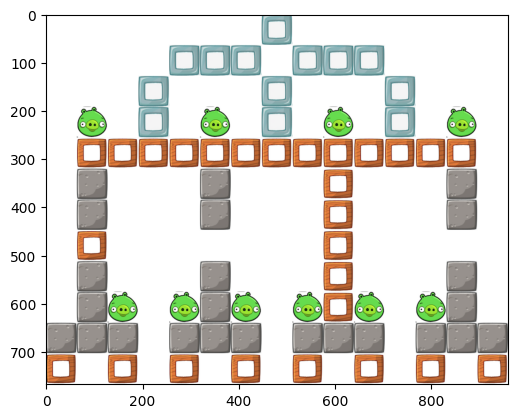

In [69]:
tile_name_to_image = {}
tiles = ["empty", "ice", "stone", "wood", "pig", "tnt"]
for i in range(len(tiles)):
    tile_name_to_image[i] = Image.open(f'angry_birds_tiles/{tiles[i]}.png')
    
tile_dim = tile_name_to_image[0].size

display_level_image(tile_dim, levels[55], tile_name_to_image)

# make network arhcitecture

In [75]:
num_classes = 6
latent_dim = 4
level_shape = (12,15,1)

# DOWN CONV
encoder_input = tf.keras.Input(shape=level_shape)
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(encoder_input)
conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same",activation="relu")(conv_1)
conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(conv_2)
flatten = tf.keras.layers.Flatten()(conv_3)

# Mu and Sigma
encoder_output = tf.keras.layers.Dense(128, activation="relu")(flatten)
z_mu = tf.keras.layers.Dense(latent_dim)(encoder_output)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(encoder_output)

# sample re-param trick
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.random.normal(
        shape=(tf.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + tf.exp(z_log_sigma) * epsilon
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_sigma])

# UP CONV
dense_1 = tf.keras.layers.Dense(128, activation="relu")(z)
dense_2 = tf.keras.layers.Dense(np.prod(np.shape(conv_3)[1:]), activation="relu")(dense_1)
reshape = tf.keras.layers.Reshape(np.shape(conv_3)[1:])(dense_2)

conv_4 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3,padding="same",activation="relu")(reshape)
conv_5 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3,padding="same",activation="relu")(conv_4)
conv_6 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, padding="same",activation="relu")(conv_5)

decoder_output = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=3,padding="same",activation="softmax")(conv_6)
flattened_output = tf.keras.layers.Reshape((12*15*num_classes,))(decoder_output)

concattenated_output = tf.keras.layers.Concatenate()([flattened_output, z_mu, z_log_sigma])

def vae_loss(y_true, output, kl_loss_weight=0.1):
    y_pred = output[:,0:12*15*num_classes]
    y_pred = tf.reshape(y_pred, shape=(-1, 12, 15, num_classes))

    z_mu = output[:,12*15*num_classes: 12*15*num_classes + latent_dim]
    z_log_sigma = output[:,12*15*num_classes + latent_dim: 12*15*num_classes + latent_dim*2]
    
    reconstruction_loss = tf.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(y_true, y_pred)) * 12 * 15
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_sigma - z_mu**2 - tf.exp(z_log_sigma), axis=-1)
    res = kl_loss_weight * kl_loss + reconstruction_loss
    return res
        
vae_cnn = tf.keras.Model(inputs=encoder_input, outputs=concattenated_output)
vae_cnn.compile(optimizer='adam', loss=vae_loss)
vae_cnn.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 12, 15, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 12, 15,    │        320 │ input_layer_24[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 12, 15,    │     18,496 │ conv2d_72[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 12, 15,    │     36,928 │ conv2d_73[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 11520)     │          0 │ conv2d_74[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 128)       │  1,474,688 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 4)         │        516 │ dense_90[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 4)         │        516 │ dense_90[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, 4)         │          0 │ dense_91[0][0],   │
│                     │                   │            │ dense_92[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 128)       │        640 │ lambda_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 11520)     │  1,486,080 │ dense_93[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_36          │ (None, 12, 15,    │          0 │ dense_94[0][0]    │
│ (Reshape)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_54 │ (None, 12, 15,    │     36,928 │ reshape_36[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_55 │ (None, 12, 15,    │     36,928 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_56 │ (None, 12, 15,    │     18,464 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 12, 15, 6) │      1,734 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_37          │ (None, 1080)      │          0 │ conv2d_75[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 1088)      │          0 │ reshape_37[0][0], │
│ (Concatenate)       │                   │            │ dense_91[0][0],   │
│                     │                   │            │ dense_92[0][0]    │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 3,112,238 (11.87 MB)

 Trainable params: 3,112,238 (11.87 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
x = levels.reshape((levels.shape[0], levels.shape[1], levels.shape[2], 1))

vae_cnn.fit(x=x, y=x, epochs=100, batch_size=8)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 407.1272
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 239.9028
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 216.2016
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 202.4264
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 201.6951
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 195.1394
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 195.2353
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 185.4968
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 189.4123
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 182.0335
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 182.4972
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 193.3565
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 185.7689
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 176.5770
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss

# Generate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
(12, 15, 6)


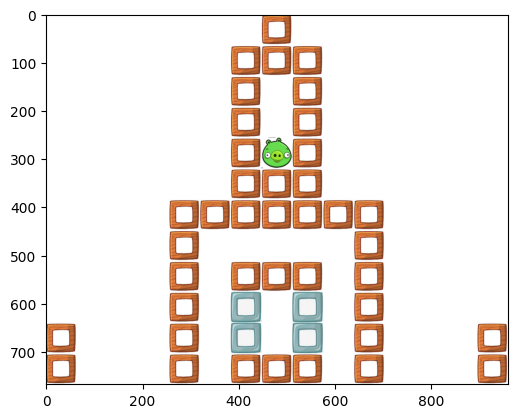

In [77]:
test = x[0]
gen = vae_cnn.predict(test.reshape(1,12,15,1))[0][:12*15*6].reshape((12,15,num_classes))
print(gen.shape)

generated_level = np.argmax(gen, axis=2)

display_level_image(tile_dim, generated_level, tile_name_to_image)

In [78]:
decoder_input = tf.keras.Input(shape=(latent_dim,))
decoder_layer = vae_cnn.layers[-9](decoder_input)
decoder_layer = vae_cnn.layers[-8](decoder_layer)
decoder_layer = vae_cnn.layers[-7](decoder_layer)
decoder_layer = vae_cnn.layers[-6](decoder_layer)
decoder_layer = vae_cnn.layers[-5](decoder_layer)
decoder_layer = vae_cnn.layers[-4](decoder_layer)
decoder_layer = vae_cnn.layers[-3](decoder_layer)
decoder = tf.keras.Model(decoder_input, decoder_layer)

encoder = tf.keras.Model(encoder_input, z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


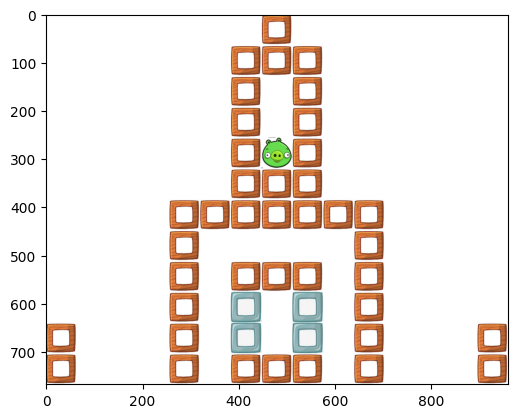

In [86]:
vector_one = encoder.predict(np.array(x[0]).reshape(1, 12, 15, 1))[0]
vector_two = encoder.predict(np.array(x[1]).reshape(1, 12, 15, 1))[0]

a = 1.0
vector = vector_one * a + vector_two * (1-a)

gen = decoder.predict(np.array(vector).reshape(1,latent_dim))[0]
generated_level = np.argmax(gen, axis=2)
display_level_image(tile_dim, generated_level, tile_name_to_image)